In [5]:
# cost function basics

import numpy as np

# Sigmoid and its derivative
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    s = sigmoid(x)
    return s * (1 - s)

# Inputs
x = np.array([0.5, 0.1])  # shape: (2,)
target = np.array([1.0, 0.0, 1.0])  # shape: (3,)

# Weights for 3 output neurons (shape: (3, 2))
W = np.array([
    [0.2, -0.3],
    [0.4,  0.1],
    [-0.5, 0.2]
])
print(W)

# Forward pass
z = W @ x  # shape: (3,)
y = sigmoid(z)

# Compute cost (MSE)
cost = np.mean((y - target)**2)

# Backward pass: gradient of cost w.r.t. output
dCost_dy = 2 * (y - target) / y.size

# Gradient of output w.r.t. z (because y = sigmoid(z))
dy_dz = sigmoid_deriv(z)

# Gradient of cost w.r.t. z
dCost_dz = dCost_dy * dy_dz  # shape: (3,)

# Gradient of cost w.r.t. weights
# We need outer product of dCost_dz (3,) and x (2,)
dCost_dW = np.outer(dCost_dz, x)  # shape: (3, 2)

# Update weights
learning_rate = 0.1
W -= learning_rate * dCost_dW

print(W)


[[ 0.2 -0.3]
 [ 0.4  0.1]
 [-0.5  0.2]]
[[ 0.20401597 -0.29919681]
 [ 0.39544781  0.09908956]
 [-0.49541714  0.20091657]]


WARNING    'i' is an internal variable of group 'synapses_6', but also exists in the run namespace with the value 16. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 3 lines of abstract code, first line is: 'spikes_received += 1 (in-place)'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 3 lines of abstract code, first line is: 'spikes_received += 1 (in-place)'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore

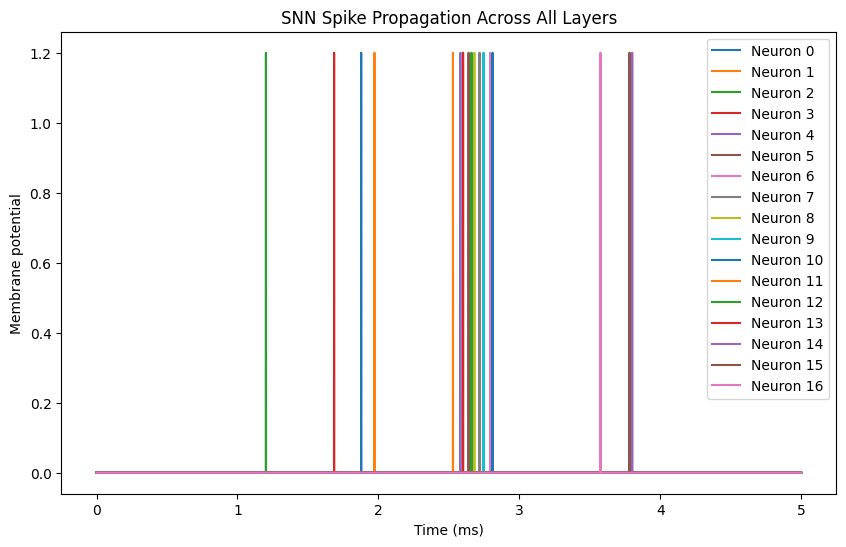

[0.         0.         0.         ... 0.97153423 0.97153423 0.97153423]
[0. 0. 0. ... 1. 1. 1.]
[1.00000000e+06 1.00000000e+06 1.00000000e+06 ... 1.97153423e-06
 1.97153423e-06 1.97153423e-06] ks
Neuron 0 spike times: ['1.878 ms']
Neuron 1 spike times: ['1.972 ms']
Neuron 2 spike times: ['1.202 ms']
Neuron 3 spike times: ['1.686 ms']
Neuron 4 spike times: ['2.582 ms']
Neuron 5 spike times: ['2.640 ms']
Neuron 6 spike times: ['2.793 ms']
Neuron 7 spike times: ['2.718 ms']
Neuron 8 spike times: ['2.681 ms']
Neuron 9 spike times: ['2.746 ms']
Neuron 10 spike times: ['2.810 ms']
Neuron 11 spike times: ['2.529 ms']
Neuron 12 spike times: ['2.661 ms']
Neuron 13 spike times: ['2.601 ms']
Neuron 14 spike times: ['3.801 ms']
Neuron 15 spike times: ['3.782 ms']
Neuron 16 spike times: ['3.576 ms']


In [3]:
from brian2 import *
import numpy as np

start_scope()

defaultclock.dt = 0.0001*ms  

# Custom timing function
@implementation('numpy', discard_units=True)
@check_units(w=1, global_clock=1, layer=1, result=1, sum=1, spikes_received=1)
def spike_timing(w, global_clock, layer, sum, spikes_received): 
    #print(global_clock)
    x = global_clock % 1
    if w >= 0:
       # print((x ** (1 - w)))
        return (x ** (1 - w)) 
    else:
        #print((1 - (1 - x) ** (1 + w)))
        return (1 - (1 - x) ** (1 + w)) 
    
@implementation('numpy', discard_units=True)
@check_units(layer=1, result=1, sum=1, spikes_received=1)
def math1(layer, sum, spikes_received): 
    #print(spikes_received, sum)
    return (sum/spikes_received )+ layer

# Define network sizes
n_input = 4
n_hidden = 10
n_output = 3
n_total = n_input + n_hidden + n_output

# Full neuron group
neurons = NeuronGroup(n_total, '''
    v : 1
    sum : 1
    spikes_received : 1
    scheduled_time : second
    global_clock : 1
''', threshold='v > 1', reset='v = 0', method='exact')

neurons.v = 0
neurons.scheduled_time = 1e9 * second
neurons.global_clock = 0.0
neurons.sum = 0.0
neurons.spikes_received = 0.0

# Spike inputs (one per input neuron)     times=[i*0.4 for i in range(n_input)]
stim = SpikeGeneratorGroup(n_input, indices=range(n_input), times=(np.random.uniform(0.005, .995, size=4) * ms))

# Input → Hidden connections
syn_input = Synapses(stim, neurons[0:n_input], '''
    w : 1
    layer : 1
''', on_pre='''
    spikes_received += 1
    sum += spike_timing(w, global_clock, layer, spikes_received, sum)
    scheduled_time = ((sum/spikes_received) + layer) * ms 
''')
syn_input.connect(j='i')  # connect stim[i] to neurons[i]
syn_input.w = np.random.uniform(0.10, 0.95, size=4)
syn_input.layer = 1

# Hidden layer: input → hidden
syn_hidden = Synapses(neurons[0:n_input], neurons[n_input:n_input + n_hidden], '''
    w : 1
    layer : 1
''', on_pre='''
    spikes_received += 1
    sum += spike_timing(w, global_clock, layer, spikes_received, sum)
    scheduled_time = ((sum/spikes_received) + layer) * ms 
''')
syn_hidden.connect()
syn_hidden.w = np.random.uniform(-0.90, 0.90, size=40) #[ 0.1135968 ,  0.18025309,  0.10094303, -0.5609372 , -0.19758941, -0.20204231, -0.3657724 ,  0.02413964, -0.6838493 ,  0.13974035, -0.4299119 ,  0.6738531 ,  0.9506301 , -0.18848935,  0.14345719, -0.48180234,  0.00865681,  0.01765617,  0.17112266, -0.08891857, -0.09449631, -0.8266945 , -1.235361  ,  0.14157972,  0.51368946, 0.321979  , -0.1708726 ,  0.07350195, -0.24007349, -0.5640322, -0.08869338, -0.745832  , -0.36420307,  0.36688203,  0.85630447, -0.5828457 , -0.5360476 ,  0.82350487, -0.12507023, -0.4661583 ]
#np.random.uniform(0.10, 0.90, size=40)
syn_hidden.layer = 2

# Output layer: hidden → output
syn_output = Synapses(neurons[n_input:n_input + n_hidden], neurons[n_input + n_hidden:n_total], '''
    w : 1
    layer : 1
''', on_pre='''
    spikes_received += 1
    sum += spike_timing(w, global_clock, layer, spikes_received, sum)
    scheduled_time = ((sum/spikes_received) + layer) * ms 
   
''')
syn_output.connect()
syn_output.w = np.random.uniform(-0.90, .90, size=30) # [ 0.7116071 , -1.1385437 , -1.088651, 0.43341887, -1.4892002 , -1.3539809 ,0.28178445,  0.152175  , -0.54456943, -1.5054257 ,  0.12284008,  0.49124786, -0.41317764,  0.5724888 ,  0.4868003, 0.38319886,  0.31672755,  0.5698485, -0.7893439 , -0.4332046 ,  1.1470755, -0.619324  , -0.6091148 , -0.2407385, -0.02582   , -0.17720485,  0.3123896, -0.01638766,  0.39673412, -0.4153284 ]
#np.random.uniform(0.10, .90, size=30)
syn_output.layer = 3

# Scheduled activation & clock update
neurons.run_regularly('''
    v = int(abs(t - scheduled_time) < 0.0005*ms) * 1.2
                      
    global_clock += 0.001
''', dt=0.001*ms)

# Monitors
mon = StateMonitor(neurons, 'v', record=True, dt=0.001*ms)
mon_sum = StateMonitor(neurons, 'sum', record=True)
sp_mon = StateMonitor(neurons, 'spikes_received', record=True)
sch_time = StateMonitor(neurons, 'scheduled_time', record=True)


spikemon = SpikeMonitor(neurons)


run(5*ms)

# # Plot voltages
figure(figsize=(10, 6))
for i in range(n_total):  # All neurons
    plot(mon.t/ms, mon.v[i], label=f'Neuron {i}')
xlabel('Time (ms)')
ylabel('Membrane potential')
legend()
title('SNN Spike Propagation Across All Layers')
show()

#plot(mon_sum.t/ms, mon_sum.sum[4])  # or any neuron index
print(mon_sum.sum[1])
print(sp_mon.spikes_received[1])
print(sch_time.scheduled_time[1])

for i in range(n_total):
    times = spikemon.spike_trains()[i]
    if len(times) > 0:
        formatted_times = [f"{t/ms:.3f} ms" for t in times]
        print(f"Neuron {i} spike times: {formatted_times}")


